In [1]:
# Check GPU availability
import tensorflow as tf
print("GPUs Available:", tf.config.list_physical_devices('GPU'))

GPUs Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [2]:
# !pip install scikeras --quiet
!pip install keras-tuner --quiet

import keras_tuner as kt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
# from scikeras.wrappers import KerasClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
# from tensorflow.keras.layers import Dense, Dropout
# from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam, RMSprop
from xgboost import XGBClassifier

tf.random.set_seed(42)
np.random.seed(42)

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
# Load and optimize data
def reduce_memory_usage(df):
    """Downcasts numeric columns to reduce memory usage."""
    for col in df.select_dtypes(include=['int64', 'float64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='float')
    return df

train = pd.read_csv('/kaggle/input/playground-series-s5e3/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e3/test.csv')

train = reduce_memory_usage(train)
test = reduce_memory_usage(test)

# Split train into features and target; store test ids separately
X = train.drop(['id', 'rainfall'], axis=1)
y = train['rainfall']

test_ids = test['id']
X_test = test.drop(['id'], axis=1)

## Advanced Feature Engineering

This function creates many new features. It:
- Builds a date from the 'day' column (assuming day 1 = 2024-01-01),
- Extracts date-based features (month, day_of_year, week_of_year, quarter, day_of_week, is_weekend),
- Creates periodic features,
- Computes interaction/ratio features (e.g., temp_range, humidity_cloud_ratio),
- And, if training data, calculates lag features (gap_before_rain, gap_after_rain).  
For test data, gap features are set to 0.ain`.


In [4]:
def advanced_features(df, is_train=False, target_series=None):
    """
    Create advanced features.
    Assumes:
      - 'day' column exists.
      - For training data (is_train=True), target_series (rainfall) is provided.
    """
    df = df.copy()
    
    # Build date: day=1 corresponds to 2024-01-01
    base_date = pd.to_datetime('2024-01-01')
    df['date'] = base_date + pd.to_timedelta(df['day'] - 1, unit='D')
    
    # Extract month (crucial for consistency)
    df['month'] = df['date'].dt.month
    
    # Date-based features
    df['day_of_year'] = df['date'].dt.dayofyear
    df['week_of_year'] = df['date'].dt.isocalendar().week.astype(int)
    df['quarter'] = df['date'].dt.quarter
    # df['day_of_week'] = df['date'].dt.weekday
    # df['is_weekend'] = df['day_of_week'].isin([5,6]).astype(int)
    
    # Periodic features
    df['day_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
    df['day_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    
    # Temperature features
    if 'maxtemp' in df.columns and 'mintemp' in df.columns:
        df['temp_range'] = df['maxtemp'] - df['mintemp']
    if 'temparature' in df.columns and 'dewpoint' in df.columns:
        df['temp_dew_diff'] = df['temparature'] - df['dewpoint']
    
    # Interaction/Ratio features
    if 'humidity' in df.columns and 'cloud' in df.columns:
        df['humidity_cloud_ratio'] = df['humidity'] / (df['cloud'] + 1e-3)
    if 'sunshine' in df.columns and 'cloud' in df.columns:
        df['sunshine_cloud_ratio'] = df['sunshine'] / (df['cloud'] + 1e-3)
    if 'pressure' in df.columns and 'winddirection' in df.columns:
        df['pressure_wind_interaction'] = df['pressure'] * df['winddirection']
    if 'temparature' in df.columns and 'pressure' in df.columns:
        df['temp_pressure_ratio'] = df['temparature'] / (df['pressure'] + 1e-3)
    if 'windspeed' in df.columns and 'pressure' in df.columns:
        df['wind_pressure_ratio'] = df['windspeed'] / (df['pressure'] + 1e-3)
    
    # Lag features (for training data)
    if is_train:
        if target_series is not None:
            df['rainfall'] = target_series.values
        df = df.sort_values('date').reset_index(drop=True)
        df['rain_prev_day'] = df['rainfall'].shift(1).fillna(0)
        df['rain_next_day'] = df['rainfall'].shift(-1).fillna(0)
        df['gap_before_rain'] = df.groupby((df['rain_prev_day'] != df['rainfall']).cumsum()).cumcount()
        df['gap_after_rain'] = df[::-1].groupby((df['rain_next_day'] != df['rainfall']).cumsum()).cumcount()
        df.drop(['rain_prev_day', 'rain_next_day'], axis=1, inplace=True)
    else:
        # For test data, set gap features to 0
        df['gap_before_rain'] = 0
        df['gap_after_rain'] = 0
    
    # Drop the date column to avoid leakage
    df.drop(['date'], axis=1, inplace=True, errors='ignore')
    
    return df

# Apply advanced features to train and test
X_fe_full = advanced_features(pd.concat([X, y], axis=1), is_train=True, target_series=y)
y_fe = X_fe_full.pop('rainfall')
X_test_fe_full = advanced_features(X_test, is_train=False)

print("Enhanced Train Shape:", X_fe_full.shape)
print("Enhanced Test Shape:", X_test_fe_full.shape)

Enhanced Train Shape: (2190, 28)
Enhanced Test Shape: (730, 28)


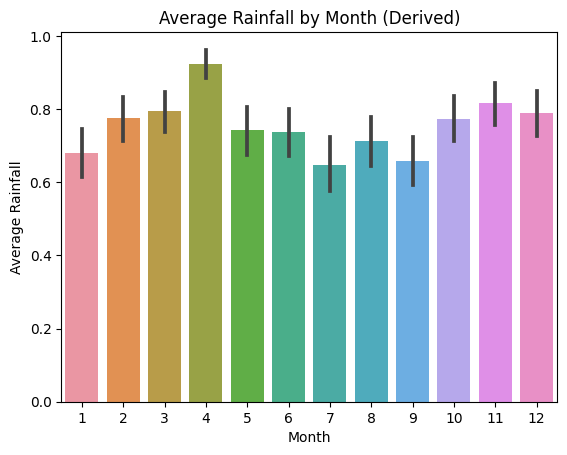

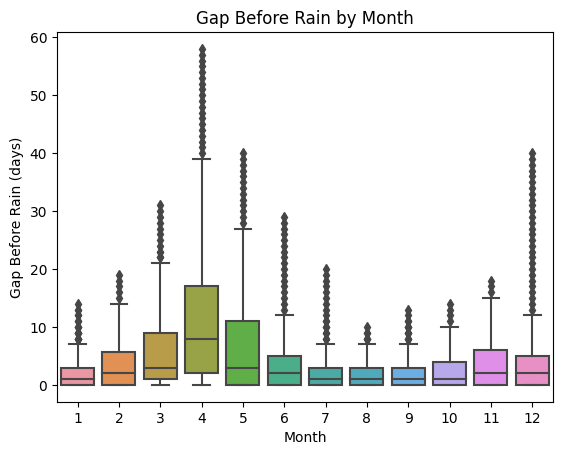

In [5]:
# Create a barplot for average rainfall by month
sns.barplot(x='month', y=y_fe, data=X_fe_full)
plt.title("Average Rainfall by Month (Derived)")
plt.xlabel("Month")
plt.ylabel("Average Rainfall")
plt.show()

# Create a boxplot for gap_before_rain by month
sns.boxplot(x='month', y='gap_before_rain', data=X_fe_full)
plt.title("Gap Before Rain by Month")
plt.xlabel("Month")
plt.ylabel("Gap Before Rain (days)")
plt.show()

## Outlier Treatment (IQR Method)

We apply IQR-based clipping to reduce the impact of extreme values in the engineered features.


In [6]:
def treat_outliers_iqr(df):
    df = df.copy()
    for col in df.select_dtypes(include=['float', 'int']).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df[col] = np.clip(df[col], lower, upper)
    return df

X_fe_iqr = treat_outliers_iqr(X_fe_full)
X_test_fe_iqr = treat_outliers_iqr(X_test_fe_full)

## Define Pipeline Function for Model Training and Submission

This helper function builds a pipeline (imputation → scaling → model), performs hyperparameter tuning using RandomizedSearchCV, and saves a submission file.  
We convert the test input to a NumPy array to avoid feature-name issues.


In [7]:
# def train_and_submit(X_train, y_train, X_pred, model, param_dist, model_name, scaler_choice='standard'):
#     """
#     Trains a model using a pipeline that includes imputation and scaling.
#     Performs hyperparameter tuning using RandomizedSearchCV.
#     Saves submission CSV named model_name_submission.csv.
#     Returns the best CV AUC score.
#     """
#     pipeline = Pipeline([
#         ('imputer', SimpleImputer(strategy='median')),
#         ('scaler', StandardScaler()),
#         ('clf', model)
#     ])
    
#     cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#     search = RandomizedSearchCV(pipeline, param_dist, n_iter=20, scoring='roc_auc', cv=cv, random_state=42, n_jobs=-1)
#     search.fit(X_train, y_train)
    
#     best_score = search.best_score_
#     print(f"Best CV ROC AUC for {model_name}: {best_score:.4f}")
#     print("Best Params:", search.best_params_)
    
#     # Try predicting probabilities. If an error occurs (e.g., for XGBoost), fallback to default prediction.
#     try:
#         preds = search.predict_proba(X_pred.values)[:, 1]
#     except Exception as e:
#         print(f"Error in predict_proba for {model_name}: {e}")
#         print("Using default predictions of 0.5")
#         preds = np.full(len(X_pred), 0.5)
    
#     submission = pd.DataFrame({'id': test_ids, 'rainfall': preds})
#     submission.to_csv(f"{model_name}_submission.csv", index=False)
#     return best_score

## Cell 7: Train Multiple Models

We define parameter grids for various models and train them on the IQR-treated, Standard Scaled engineered features.  
We save each model's submission file with a unique name.

In [8]:
# # Define parameter grids for each model:
# param_grids = {
#     'LogisticRegression': {
#         'clf__C': np.logspace(-3, 2, 10),
#         'clf__solver': ['lbfgs', 'liblinear']
#     },
#     'DecisionTree': {
#         'clf__max_depth': [3,5,7,None],
#         'clf__min_samples_split': [2,5,10]
#     },
#     'ExtraTrees': {
#         'clf__n_estimators': [50,100,150],
#         'clf__max_depth': [5,7,None]
#     },
#     'RandomForest': {
#         'clf__n_estimators': [50,100,150],
#         'clf__max_depth': [5,7,None]
#     },
#     'XGBoost': {
#         'clf__n_estimators': [50,100,150],
#         'clf__max_depth': [3,5,7]
#     },
#     'CatBoost': {
#         'clf__iterations': [100,200],
#         'clf__depth': [4,6]
#     },
#     'LGBM': {
#         'clf__num_leaves': [31,50],
#         'clf__n_estimators': [50,100,150]
#     },
#     'KNN': {
#         'clf__n_neighbors': [3,5,7],
#         'clf__weights': ['uniform','distance']
#     },
#     'SVC': {
#         'clf__C': [0.1,1,10],
#         'clf__kernel': ['linear','rbf']
#     }
# }

# models = {
#     'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
#     'DecisionTree': DecisionTreeClassifier(random_state=42),
#     'ExtraTrees': ExtraTreesClassifier(random_state=42, n_jobs=-1),
#     'RandomForest': RandomForestClassifier(random_state=42, n_jobs=-1),
#     'XGBoost': XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42),
#     'CatBoost': CatBoostClassifier(verbose=0, random_state=42),
#     'LGBM': LGBMClassifier(random_state=42),
#     'KNN': KNeighborsClassifier(),
#     'SVC': SVC(probability=True, random_state=42)
# }

# model_results = {}
# for model_name, model in models.items():
#     print(f"\nTraining {model_name} on IQR-treated & Standard Scaled features:")
#     auc = train_and_submit(X_fe_iqr, y_fe, X_test_fe_iqr, model, param_grids[model_name], model_name)
#     model_results[model_name] = auc

## Train Expanded DNN

We train an expanded DNN using scikeras with an expanded hyperparameter grid on the IQR-treated, Standard Scaled features.


In [9]:
def build_model(hp):
    model = keras.Sequential()
    # Input layer: shape = number of features in X_fe_iqr
    input_shape = (X_fe_iqr.shape[1],)
    model.add(layers.InputLayer(input_shape=input_shape))
    
    # Number of hidden layers (between 2 and 4)
    num_layers = hp.Int('num_layers', min_value=2, max_value=4, step=1)
    for i in range(num_layers):
        # Units in the i-th layer (32 to 128 in steps of 32)
        units = hp.Int(f'units_{i}', min_value=32, max_value=128, step=32)
        model.add(layers.Dense(units, activation='relu'))
        # Dropout rate (0.2 to 0.4)
        dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.4, step=0.1)
        model.add(layers.Dropout(dropout_rate))
    
    # Output layer for binary classification
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # Choose optimizer and learning rate
    optimizer_choice = hp.Choice('optimizer', values=['adam', 'rmsprop'])
    learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 5e-4])
    
    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    else:
        optimizer = RMSprop(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[keras.metrics.AUC(name='auc')])
    return model

In [10]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_auc',
    max_trials=50,              # Total number of models to try
    executions_per_trial=1,     # Number of executions per trial
    directory='dnn_tuning',
    project_name='rainfall_dnn',
    overwrite=True,
    seed=42
)

In [11]:
tuner.search(X_fe_iqr, y_fe, epochs=30, validation_split=0.2, batch_size=32)

Trial 50 Complete [00h 00m 13s]
val_auc: 0.5

Best val_auc So Far: 0.6169289946556091
Total elapsed time: 00h 09m 16s


In [12]:
# Get the best hyperparameters and best model
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
print(best_hp.values)

best_model = tuner.get_best_models(num_models=1)[0]
# Optionally evaluate on the training set
train_metrics = best_model.evaluate(X_fe_iqr, y_fe, verbose=0)
print("Training AUC of best model:", train_metrics[1])

# Predict probabilities on the test set
# We convert test DataFrame to NumPy array to avoid feature-name issues.
dnn_preds = best_model.predict(X_test_fe_iqr)
dnn_preds = dnn_preds.flatten()  # Flatten predictions to 1D array

# Save submission CSV
submission = pd.DataFrame({'id': test_ids, 'rainfall': dnn_preds})
submission.to_csv("submission.csv", index=False)
print("DNN submission saved as 'DNN_submission.csv'")

Best Hyperparameters:
{'num_layers': 2, 'units_0': 32, 'dropout_rate': 0.2, 'units_1': 96, 'optimizer': 'adam', 'learning_rate': 0.0005, 'units_2': 128, 'units_3': 64}
Training AUC of best model: 0.5125415325164795
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
DNN submission saved as 'DNN_submission.csv'


## Graphical Comparison of Model Performances

We create a bar plot to compare the ROC AUC scores for all models.


In [13]:
# results_df = pd.DataFrame(model_results.items(), columns=['Model', 'AUC']).sort_values(by='AUC', ascending=False)
# plt.figure(figsize=(10,6))
# sns.barplot(x='AUC', y='Model', data=results_df, palette='viridis')
# plt.title('Model Comparison (After IQR & Standard Scaling)')
# plt.xlabel('ROC AUC')
# plt.xlim(0.75, 1.0)
# plt.show()

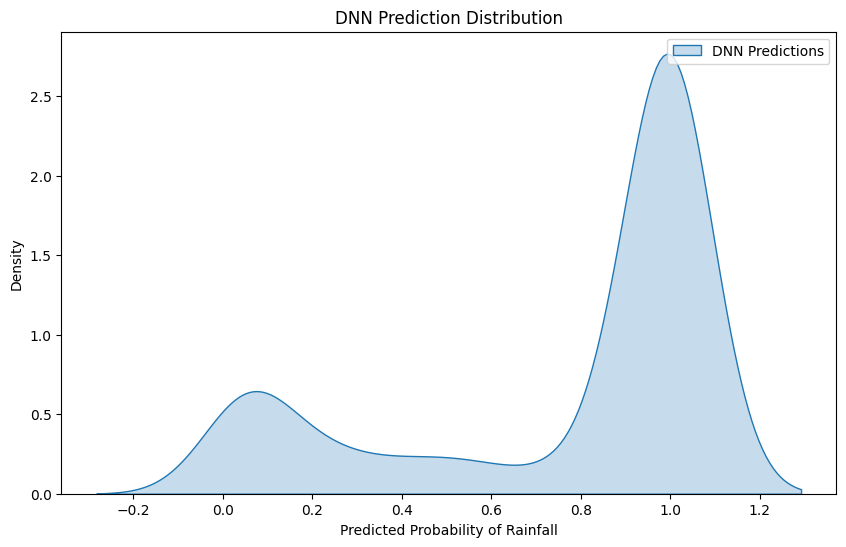

In [14]:
plt.figure(figsize=(10,6))
sns.kdeplot(dnn_preds, fill=True, label='DNN Predictions')
plt.title("DNN Prediction Distribution")
plt.xlabel("Predicted Probability of Rainfall")
plt.ylabel("Density")
plt.legend()
plt.show()

In [15]:
# import shutil

# # Define mapping for submission file names (assumes each model saved a CSV with its model name)
# submission_files = {
#     'LogisticRegression': "IQR_LogisticRegression_submission.csv",
#     'DecisionTree': "IQR_DecisionTree_submission.csv",
#     'ExtraTrees': "IQR_ExtraTrees_submission.csv",
#     'RandomForest': "IQR_RandomForest_submission.csv",
#     'XGBoost': "IQR_XGBoost_submission.csv",
#     'CatBoost': "IQR_CatBoost_submission.csv",
#     'LGBM': "IQR_LGBM_submission.csv",
#     'KNN': "IQR_KNN_submission.csv",
#     'SVC': "IQR_SVC_submission.csv",
#     'DNN': "IQR_DNN_submission.csv"
# }

# # Identify best model based on our model_results dictionary
# best_model = max(model_results, key=model_results.get)
# best_submission_file = submission_files.get(best_model)

# if best_submission_file is None:
#     raise ValueError("Best model submission file not found.")

# shutil.copy(best_submission_file, "submission.csv")
# print(f"Best scoring submission ({best_submission_file}) copied as 'submission.csv'")